### Описание задания

Классификация по тональности отзывов на банки с сайта banki.ru.
Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.
Тексты хранятся в json-ах в массиве responses.

### Задачи
**Часть 1. Анализ текстов**

**1.1** Посчитать количество отзывов в разных городах и на разные банки

**1.2** Построить гистограмы длин слов отзывов в символах и в словах

**1.3** Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

**1.4** Построить кривые Ципфа и Хипса

**1.5** Ответить на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

**1.6** В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Использовать меру для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

**Часть 2. Тематическое моделирование**

**2.1** Построить несколько тематических моделей коллекции документов с разным числом тем. Привести примеры понятных (интерпретируемых) тем.

**2.2** Найти темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

**Часть 3. Классификация текстов**

**3.1** Сформулировать для простоты задачу бинарной классификации: классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

**3.2** Составить обучающее и тестовое множество: выбрать из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Использовать sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

**3.3** Использовать любой известный алгоритм классификации текстов для решения задачи и получите baseline. Сравнить разные варианты векторизации текста: с использованием только униграм, пар или троек слов или с использованием символьных n-грам.

**3.4** Сравнить, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:

- преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD);
- тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [142]:
import bz2
import gdown
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pymorphy2
import re
import regex
import seaborn as sns

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
from string import punctuation
from tqdm import tqdm

from gensim import similarities
from gensim.corpora import Dictionary
from gensim.models import lsimodel, TfidfModel

from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.metrics  import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

### Скачивание данных

In [3]:
url = 'https://drive.google.com/uc?id=1OelGGXPXBinXvZnDb1Bmmxe4rtdBmqdk'

In [4]:
gdown.download(url, quiet=True)

'banki_responses.json.bz2'

In [5]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:52, 3844.34it/s]


In [6]:
size = len(responses)
size

153499

### Часть 1. Анализ текстов
#### 1.1 Посчитать количество отзывов в разных городах и на разные банки

In [7]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [8]:
city_response = df['city'].value_counts()
city_response.head(10)

г. Москва             55354
г. Санкт-Петербург    14342
г. Екатеринбург        2337
г. Новосибирск         2300
г. Нижний Новгород     1976
г. Ростов-на-Дону      1891
г. Самара              1731
г. Челябинск           1507
г. Казань              1440
г. Краснодар           1262
Name: city, dtype: int64

In [9]:
banks_response = df['bank_name'].value_counts()
banks_response.head(10)

Сбербанк России              26327
Альфа-Банк                   10224
ВТБ 24                        8185
Русский Стандарт              7943
Хоум Кредит Банк              7549
Тинькофф Банк                 5387
Национальный Банк «Траст»     4607
Ренессанс Кредит              3849
Связной Банк                  3775
ОТП Банк                      3237
Name: bank_name, dtype: int64

#### 1.2 Построить гистограмы длин отзывов в символах и в словах
Подсчёт будем производить сразу исключая стоп-слова и пунктуацию

In [11]:
noise = stopwords.words('russian') + list(punctuation)

In [12]:
vec_words = CountVectorizer(ngram_range=(1, 1), stop_words=noise)
bow_words = vec_words.fit_transform(df['text'])
vec_symbol = CountVectorizer(analyzer='char')
bow_symbol = vec_symbol.fit_transform(df['text'])

In [13]:
ln_words = []
ln_symbol = []
for i in tqdm(range(size)):
    ln_words.append(np.sum(bow_words[i].todense()))
    ln_symbol.append(np.sum(bow_symbol[i].todense()))

100%|█████████████████████████████████████████████████████████████████████████| 153499/153499 [03:20<00:00, 764.01it/s]


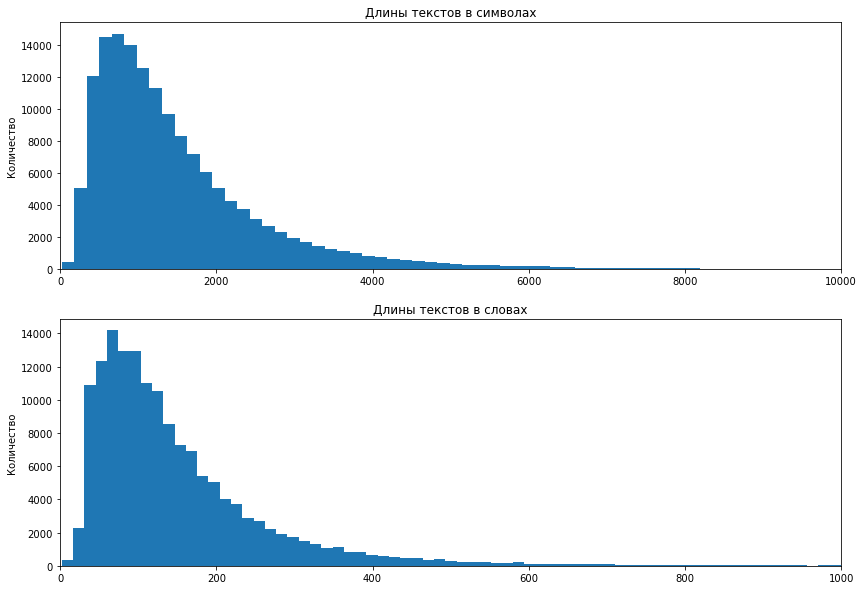

In [14]:
fig, axes = plt.subplots(2, 1,figsize=(14,10))

axes[0].hist(ln_symbol, bins = 200)
axes[1].hist(ln_words, bins = 200)
axes[0].set_xlim(0, 10000)
axes[1].set_xlim(0, 1000)
axes[0].set_title('Длины текстов в символах')
axes[1].set_title('Длины текстов в словах')
axes[0].set_ylabel('Количество')
axes[1].set_ylabel('Количество')
fig.show()

#### 1.3 Найдите 10 самых частых:

- слов

In [15]:
corpus = [token for response in df.text for token in word_tokenize(response) if token not in punctuation]
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('в', 1169557),
 ('и', 980761),
 ('не', 816419),
 ('на', 638715),
 ('что', 603171),
 ('я', 443478),
 ('с', 428021),
 ('по', 338743),
 ('мне', 293980),
 ('банка', 235176)]

- слов без стоп-слов

In [26]:
stopword = stopwords.words('russian')
punkts = ['``', '...', "''", '""', '..', '....']
for val in punkts:
    stopword.append(val)

In [28]:
corpus_without_stop = []
for word in tqdm(corpus):
    if word.lower() not in stopword:
        corpus_without_stop.append(word)
freq_dict = Counter(corpus_without_stop)
freq_dict.most_common(10)

100%|██████████████████████████████████████████████████████████████████| 36766261/36766261 [01:26<00:00, 424977.01it/s]


[('банка', 235176),
 ('банк', 159569),
 ('это', 158915),
 ('деньги', 121777),
 ('карту', 101181),
 ('карты', 99040),
 ('день', 74627),
 ('кредит', 71823),
 ('заявление', 65006),
 ('отделение', 63424)]

- лемм

In [29]:
morph = pymorphy2.MorphAnalyzer()

In [33]:
lemmas = []
noun = []
for word in tqdm(corpus_without_stop):
    temp = morph.parse(word)[0]
    lemm = temp.normal_form
    lemmas.append(lemm)
    if temp.tag.POS == 'NOUN':
        noun.append(lemm)
freq_dict_lemm = Counter(lemmas)
freq_dict_lemm.most_common(10)

100%|██████████████████████████████████████████████████████████████████| 23470205/23470205 [1:27:37<00:00, 4463.75it/s]


[('банк', 624274),
 ('карта', 331816),
 ('это', 199740),
 ('деньга', 178337),
 ('день', 172634),
 ('мой', 167035),
 ('кредит', 154863),
 ('который', 148990),
 ('отделение', 143616),
 ('счёт', 140509)]

- существительных

In [34]:
freq_dict_noun = Counter(noun)
freq_dict_noun.most_common(10)

[('банк', 624274),
 ('карта', 331816),
 ('деньга', 178337),
 ('день', 172634),
 ('кредит', 154863),
 ('отделение', 143616),
 ('счёт', 140509),
 ('сотрудник', 133662),
 ('клиент', 132908),
 ('сумма', 110914)]

#### 1.4 Построить кривые Ципфа и Хипса

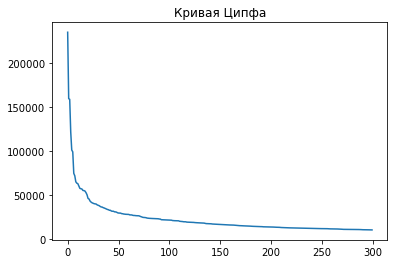

In [36]:
freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(range(300), freqs[:300])
ax.set_title(u'Кривая Ципфа', fontsize=12)
ax.set_title(u'Кривая Ципфа', fontsize=12)
plt.show()

In [38]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

100%|█████████████████████████████████████████████████████████████████████████| 153499/153499 [25:18<00:00, 101.11it/s]


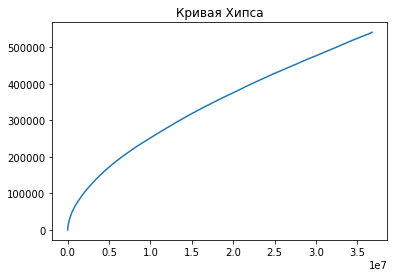

In [39]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
ax.set_title(u'Кривая Хипса', fontsize=12)
plt.show()

#### 1.5 Ответить на следующие вопросы:

- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

Для ответа на опрос используем корпус с существительными из п.1.3

In [40]:
for val in ["сотрудник", "клиент", "мошенничество", "доверие"]:
    print(val, freq_dict_noun.get(val))

сотрудник 133662
клиент 132908
мошенничество 3228
доверие 2098


**Вывод:** слово "мошенничество" встречается чаще, чем "доверие". Слова "сотрудник" и "клиент" встречаются почти с одной частотой: разница встречаемости этих слов 0.5%.

#### 1.6 В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Использовать меру для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1).

Ключевые слова будем искать, используя ещё и признак 'title', так как в нём клиент кратко обозначает суть отзыва. 

In [95]:
mystopwords = stopwords.words('russian')

ru_words = re.compile("[А-Яа-я]+")


def get_top_word(bow, count_word = 10):
    '''
    Принимает на вход результат TfidfVectorizer.fit_transform.
    Возвращает список ключевых слов
    '''
    idx = np.ravel(bow.sum(axis=0).argsort(axis=1))[::-1][:count_word]
    top_words = np.array(vec.get_feature_names_out())[idx].tolist()
    return top_words


def words_only(text):
    return " ".join(ru_words.findall(text))

def lemmatize(text):
    try:
        return  " ".join([morph.parse(word)[0].normal_form for word in text.lower().split()])
    except:
        return " "

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
 
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [66]:
lemma_df = df.copy()

In [52]:
tqdm.pandas()

In [67]:
lemma_df.text = lemma_df.text.astype('str').progress_apply(preprocess)

100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [3:25:19<00:00, 12.46it/s]


In [68]:
lemma_df.title = lemma_df.title.astype('str').progress_apply(preprocess)

100%|█████████████████████████████████████████████████████████████████████████| 153499/153499 [04:04<00:00, 627.31it/s]


In [69]:
lemma_df.head(5)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,добрый день являться клиент банк поручитель кр...,NaN
1,г. Новосибирск,False,мочь пользоваться услуга сбербанк лайна,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,добрый день являться держатель зарплатный карт...,NaN
2,г. Москва,False,двойной списание товар,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,здравствуйте дублировать свой заявление можайс...,NaN
3,г. Ставрополь,False,менять процент комиссия предупредить известить...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,добрый день открыть расчётный счёт сбербанк юр...,NaN
4,г. Челябинск,False,вернуть денежный средство страховка,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,г взять кредит ваш банк заявить сумма рубль го...,NaN


In [76]:
positive = lemma_df[lemma_df['rating_grade']==5]
negative = lemma_df[lemma_df['rating_grade']==1]

In [77]:
vec = TfidfVectorizer(ngram_range=(1, 2), stop_words=stopword)
bow_title = vec.fit(lemma_df['title'])
bow_text = vec.fit(lemma_df['text'])

In [85]:
bow_positive_title = bow_title.transform(positive['title'])
bow_positive_text = bow_text.transform(positive['text'])

In [87]:
print('Ключевые слова и биграммы для title для положительных отзывов:')
get_top_word(bow_positive_title)

Ключевые слова и биграммы для title для положительных отзывов:


['благодарность',
 'банк',
 'отличный',
 'хороший',
 'обслуживание',
 'спасибо',
 'хороший банк',
 'отличный банк',
 'довольный',
 'ипотека']

In [88]:
print('Ключевые слова и биграммы для text для положительных отзывов:')
get_top_word(bow_positive_text)

Ключевые слова и биграммы для text для положительных отзывов:


['банк',
 'карта',
 'всё',
 'очень',
 'вклад',
 'это',
 'кредит',
 'отделение',
 'клиент',
 'офис']

In [89]:
bow_negative_title = bow_title.transform(negative['title'])
bow_negative_text = bow_text.transform(negative['text'])

In [92]:
print('Ключевые слова и биграммы для title для отрицательных отзывов:')
get_top_word(bow_negative_title)

Ключевые слова и биграммы для title для отрицательных отзывов:


['банк',
 'карта',
 'деньга',
 'банкомат',
 'обслуживание',
 'отвратительный',
 'сбербанк',
 'кредит',
 'клиент',
 'ужасный']

In [93]:
print('Ключевые слова и биграммы для text для отрицательных отзывов:')
get_top_word(bow_negative_text)

Ключевые слова и биграммы для text для отрицательных отзывов:


['банк',
 'карта',
 'это',
 'деньга',
 'отделение',
 'кредит',
 'день',
 'счёт',
 'заявление',
 'сотрудник']

### Часть 2. Тематическое моделирование

#### 2.1 Построить несколько тематических моделей коллекции документов с разным числом тем. Привести примеры понятных (интерпретируемых) тем.

In [96]:
texts = [text.split() for text in lemma_df.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [97]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

Построим модели с различным числом тем: 5, 20, 501

In [100]:
lsi_5 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)
lsi_5.show_topics(5)

[(0,
  '0.195*"карта" + 0.134*"кредит" + 0.115*"деньга" + 0.109*"заявление" + 0.107*"счёт" + 0.101*"вклад" + 0.100*"банкомат" + 0.100*"отделение" + 0.097*"сбербанк" + 0.096*"сумма"'),
 (1,
  '-0.478*"вклад" + 0.332*"кредит" + 0.164*"страховка" + 0.147*"платёж" + 0.145*"задолженность" + 0.135*"погашение" + -0.129*"банкомат" + -0.128*"очередь" + -0.121*"карта" + -0.120*"открыть"'),
 (2,
  '-0.400*"вклад" + 0.264*"карта" + 0.263*"банкомат" + -0.212*"кредит" + 0.205*"сбербанк" + -0.147*"страховка" + 0.141*"операция" + -0.137*"договор" + 0.128*"средство" + 0.125*"деньга"'),
 (3,
  '-0.273*"вклад" + -0.210*"сумма" + 0.201*"заявка" + 0.200*"номер" + -0.182*"руб" + -0.166*"договор" + 0.160*"звонок" + -0.153*"платёж" + -0.147*"средство" + -0.146*"погашение"'),
 (4,
  '0.281*"вклад" + 0.278*"номер" + 0.235*"звонок" + -0.219*"страховка" + -0.191*"заявка" + 0.171*"ваш" + 0.149*"поступать" + 0.141*"персональный" + 0.139*"данные" + 0.133*"телефон"')]

In [101]:
lsi_20 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=20)
lsi_20.show_topics(5)

[(0,
  '0.194*"карта" + 0.133*"кредит" + 0.115*"деньга" + 0.109*"заявление" + 0.107*"счёт" + 0.101*"банкомат" + 0.101*"вклад" + 0.100*"отделение" + 0.096*"сбербанк" + 0.096*"сумма"'),
 (1,
  '-0.383*"вклад" + 0.358*"кредит" + -0.211*"банкомат" + -0.170*"карта" + 0.167*"страховка" + 0.149*"платёж" + 0.146*"задолженность" + 0.141*"погашение" + -0.121*"деньга" + 0.117*"звонок"'),
 (2,
  '-0.499*"вклад" + 0.277*"банкомат" + 0.218*"карта" + 0.186*"сбербанк" + 0.134*"заявление" + -0.129*"кредит" + 0.122*"операция" + 0.119*"деньга" + -0.118*"договор" + 0.118*"средство"'),
 (3,
  '-0.270*"вклад" + -0.220*"сумма" + 0.194*"номер" + -0.192*"руб" + 0.170*"заявка" + -0.158*"погашение" + -0.155*"платёж" + -0.154*"договор" + 0.148*"звонок" + -0.145*"процент"'),
 (4,
  '0.323*"вклад" + 0.270*"номер" + -0.239*"карта" + -0.217*"страховка" + -0.191*"заявка" + 0.189*"звонок" + -0.149*"кредит" + 0.138*"телефон" + 0.138*"ваш" + -0.121*"лимит"')]

In [102]:
lsi_50 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=50)
lsi_50.show_topics(5)

[(0,
  '0.194*"карта" + 0.133*"кредит" + 0.115*"деньга" + 0.109*"заявление" + 0.107*"счёт" + 0.101*"банкомат" + 0.101*"вклад" + 0.100*"отделение" + 0.096*"сбербанк" + 0.096*"сумма"'),
 (1,
  '-0.366*"вклад" + 0.364*"кредит" + -0.223*"банкомат" + -0.177*"карта" + 0.169*"страховка" + 0.146*"задолженность" + 0.142*"платёж" + 0.139*"погашение" + -0.124*"деньга" + 0.117*"звонок"'),
 (2,
  '-0.510*"вклад" + 0.272*"банкомат" + 0.212*"карта" + 0.183*"сбербанк" + 0.135*"заявление" + -0.119*"очередь" + 0.118*"операция" + -0.117*"кредит" + 0.114*"средство" + 0.114*"деньга"'),
 (3,
  '-0.260*"вклад" + -0.219*"сумма" + 0.205*"номер" + -0.189*"руб" + 0.171*"заявка" + -0.158*"погашение" + -0.156*"платёж" + -0.155*"договор" + 0.155*"звонок" + -0.146*"рубль"'),
 (4,
  '0.328*"вклад" + 0.268*"номер" + -0.259*"карта" + -0.206*"страховка" + -0.195*"заявка" + 0.189*"звонок" + 0.143*"ваш" + 0.137*"телефон" + -0.136*"кредит" + -0.127*"лимит"')]

**Вывод:** для различного числа тем для моделей изменения коснулись только размера вклада тем.
Получили понятные темы: карта, кредит, страховка, банкомат и тд.

#### 2.2 Найти темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?
Проверим первые 20 отзывов на основе модели lsi_20 на наличие тем, связанных с конкретными банками.

In [111]:
banks = ['сбербанк', 'альфа', 'втб', 'тинькофф']
responses = []

for idx in range(20):
    for response in lsi_20.show_topic(topicno=idx, topn=10):
        if response[0] in banks:
            responses.append([idx, lsi_20.show_topic(topicno=idx, topn=10)])

responses

[[0,
  [('карта', 0.19449843186668436),
   ('кредит', 0.13333041995845443),
   ('деньга', 0.11490045154092841),
   ('заявление', 0.10890373780164807),
   ('счёт', 0.10682018722587537),
   ('банкомат', 0.1012599334872163),
   ('вклад', 0.10068696632484765),
   ('отделение', 0.10036893847003552),
   ('сбербанк', 0.09635361858864562),
   ('сумма', 0.09589968369256853)]],
 [2,
  [('вклад', -0.49855451259464956),
   ('банкомат', 0.27680956196075185),
   ('карта', 0.21809568028293203),
   ('сбербанк', 0.18572642174224552),
   ('заявление', 0.13353570836490183),
   ('кредит', -0.12864067034291587),
   ('операция', 0.1216334715271755),
   ('деньга', 0.11853652747996019),
   ('договор', -0.11810494398782312),
   ('средство', 0.11794322807135532)]],
 [6,
  [('заявка', 0.2504144795411299),
   ('сбербанк', 0.24475433507137184),
   ('заявление', 0.20561149048663868),
   ('страховка', 0.19387681654053618),
   ('платёж', -0.18685556337158532),
   ('страхование', 0.1534567325558659),
   ('документ', 0

Для примера интерпритируем отзыв с idx=2, для которого указаны темы: банкомат, карта, сбербанк, заявлением, операция, деньга, средство. Можно предположить, что отзыв связан с операцией с деньгами по карте в банкомате Сбербанка, из-за которой клиенту пришлось написать заявление в банк.

### Часть 3. Классификация текстов
#### 3.1 Сформулировать для простоты задачу бинарной классификации: классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

Используем датафреймы positive и negative, полученные в п.1.6, оставим в них только text

In [129]:
data = pd.concat([positive, negative])

In [137]:
X = data['text']
y = data['rating_grade']

In [138]:
X.head()

98     досрочно закрывать вклад отпуск жена заказыват...
122    хотеть открыть вклад доходный год процент начи...
157    вчера июнь просидеть очередь х час получение с...
259    сегодня открывать вклад это банк очередь клиен...
266    история получение кредит ренессанс кредит банк...
Name: text, dtype: object

#### 3.2 Составить обучающее и тестовое множество: выбрать из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Использовать sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 21)

#### 3.3 Использовать любой известный алгоритм классификации текстов для решения задачи и получите baseline. Сравнить разные варианты векторизации текста: с использованием только униграм, пар или троек слов или с использованием символьных n-грамм

In [146]:
def random_forest_n_gram(n, analyzer='word'):
    '''Принимает размер n-gram и строит модель'''
    vec = CountVectorizer(analyzer=analyzer, ngram_range=(n, n))
    bow = vec.fit_transform(X_train)
    
    model = RandomForestClassifier(random_state=21)
    model.fit(bow, y_train)
    
    pred = model.predict(vec.transform(X_test))
    print(classification_report(pred, y_test))

In [147]:
print('Модель с использованием только униграм')
random_forest_n_gram(1)

Модель с использованием только униграм
              precision    recall  f1-score   support

         1.0       1.00      0.89      0.94     15848
         5.0       0.62      0.99      0.76      2782

    accuracy                           0.91     18630
   macro avg       0.81      0.94      0.85     18630
weighted avg       0.94      0.91      0.91     18630



In [148]:
print('Модель с использованием только биграм')
random_forest_n_gram(2)

Модель с использованием только биграм
              precision    recall  f1-score   support

         1.0       0.99      0.90      0.94     15605
         5.0       0.64      0.95      0.77      3025

    accuracy                           0.91     18630
   macro avg       0.82      0.92      0.85     18630
weighted avg       0.93      0.91      0.91     18630



In [149]:
print('Модель с использованием только триграм')
random_forest_n_gram(3)

Модель с использованием только триграм
              precision    recall  f1-score   support

         1.0       0.99      0.84      0.91     16630
         5.0       0.41      0.92      0.57      2000

    accuracy                           0.85     18630
   macro avg       0.70      0.88      0.74     18630
weighted avg       0.93      0.85      0.87     18630



In [150]:
print('Модель с использованием использованием символьных n-грамм')
random_forest_n_gram(1, analyzer='char')

Модель с использованием использованием символьных n-грамм
              precision    recall  f1-score   support

         1.0       0.98      0.80      0.88     17367
         5.0       0.21      0.76      0.33      1263

    accuracy                           0.80     18630
   macro avg       0.60      0.78      0.61     18630
weighted avg       0.93      0.80      0.84     18630



**Вывод:** модели RandomForestClassifier на основе униграмм и биграмм показали примерно одинаковую точность 0.91

#### 3.4 Сравнить, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD)

In [152]:
model_tf_idf_TruncatedSVD = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('model', RandomForestClassifier())
])

In [153]:
model_tf_idf_TruncatedSVD.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('tm', TruncatedSVD()), ('model', RandomForestClassifier())])

In [154]:
truncatedsvd_pred = model_tf_idf_TruncatedSVD.predict(X_test)
print(classification_report(truncatedsvd_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.90      0.78      0.84     16500
         5.0       0.17      0.36      0.23      2130

    accuracy                           0.73     18630
   macro avg       0.54      0.57      0.54     18630
weighted avg       0.82      0.73      0.77     18630



- тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

In [155]:
model_tf_idf_LDA = Pipeline([
     ('vect', CountVectorizer()),
     ('lda', LatentDirichletAllocation()),
     ('model', RandomForestClassifier())
])

In [156]:
model_tf_idf_LDA.fit(X_train, y_train)
lda_pred = model_tf_idf_LDA.predict(X_test)
print(classification_report(lda_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.96      0.94      0.95     14564
         5.0       0.79      0.87      0.83      4066

    accuracy                           0.92     18630
   macro avg       0.88      0.90      0.89     18630
weighted avg       0.92      0.92      0.92     18630



**Вывод:** классификация текстов на основе LDA показала куда более высокую точность 0.92 по сравнению с моделью на основе сингулярного разложения TruncatedSVD 0.73

### Выводы
В работе были рассмотрены различные аспекты классификации по тональности отзывов на банки: анализ основных характеристик, тематическое моделирование и классификация на основе классической модели RandomForestClassifier с использованием TruncatedSVD и LDA.

Модель классификации на основе LDA показал хорошую точность 0.92, при этом он превышает по скорости классическую модель RandomForestClassifier.